In [55]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cbook as cbook
import matplotlib.image as image
import re
from sklearn import linear_model

In [56]:
raw_data = pd.read_csv(r'C:\Users\1\Documents\DataSets\benchmark_analytics\full_ffa_with_years.csv', sep = ';',\
                       encoding = 'utf8').dropna(subset = ['Номер BvD'], axis = 0)

In [57]:
# define columns that are required for future analisys
exp = re.compile(r'(.*виручка(.*\n)+\d{4}|.*операційної(.*\n)+\d{4})')

In [58]:
fin_names = ['Номер BvD']
[fin_names.append(x[0][0]) for x in [re.findall(exp, y) for y in raw_data.columns] if x!=[]]  
fin_names

['Номер BvD',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2015',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2014',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2013',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2012',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2011',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2010',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2009',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2008',
 'Чиста виручка від реалізації продукції (товарів, робіт, послуг)\r\nтыс UAH\r\n2007',
 'Фінансові результати від операційної діяльності прибуток (збиток)\r\nтыс UAH\r\n2015',
 'Фінансові результати від операційної діяльності прибуток (збиток)\r\nтыс UAH\r\n2014',
 'Фінансові результати ві

In [59]:
data = pd.merge(raw_data.loc[:,['Номер BvD','Название компании','Оснвоной код NACE Rev. 2.','Город','Адрес','Дата основания']],\
                             raw_data.loc[:,fin_names], on='Номер BvD', how = 'left').\
rename(index = str, columns = {'Название компании':'name','Номер BvD':'bvdep', 'Оснвоной код NACE Rev. 2.':'nace',\
                                      'Город':'city', 'Дата основания': 'inc_year','Адрес':'adress'})
for name in fin_names:
    if re.findall(r'виручка', name)!=[]:
        data = data.rename(index = str, columns = {name: 'rev_'+re.findall(r'\d{4}', name)[0]})
    if re.findall(r'операційної', name)!=[]:
        data = data.rename(index = str, columns = {name: 'pnl_'+re.findall(r'\d{4}', name)[0]})    
data.head(2)

,bvdep,name,nace,city,adress,inc_year,rev_2015,rev_2014,rev_2013,rev_2012,...,rev_2007,pnl_2015,pnl_2014,pnl_2013,pnl_2012,pnl_2011,pnl_2010,pnl_2009,pnl_2008,pnl_2007
0,UA38390515,ВОГ ТРЕЙДИНГ ТОВ,4671.0,Киев,"вул. Академіка Філатова 22 / 8, кім. 201",2012.0,25602277,21643591,876493.2,n.a.,...,n.a.,-244975,-95293,159.4,n.a.,n.a.,n.a.,n.a.,n.a.,n.a.
1,UA35917124,ТОРГОВИЙ ДІМ АГРОІМПОРТ ЛТД ТОВ,4675.0,Киев,"вул. Метрологічна, 42, приміщення 42/1",2008.0,8916298,3405444,2951044,2695448,...,n.a.,79715,70273,41872,28134,45954.9,26375,7668,1299.6,n.a.


# set preprocessing

In [60]:
data.shape

(188744, 24)

In [61]:
def drop_missing_data(x):
    if re.findall(r'n.a.', str(x)) == []:
        return float(x)
    else:
        return np.nan

In [62]:
fin_names = re.findall(r'(\w+_\d{4})', str(data.columns))
for col_name in fin_names:
    data[col_name] = data[col_name].apply(lambda x: drop_missing_data(x))

In [63]:
#calculate means

data['rev_mean'] = data.loc[:,fin_names[1:10]].mean(axis = 1, skipna = True, numeric_only = True)
data['pnl_mean'] = data.loc[:,fin_names[10:]].mean(axis = 1, skipna = True, numeric_only = True)

# counting margins and averages

In [64]:
clean_data = data.dropna(subset = ['rev_mean', 'pnl_mean'], axis = 0)
# taking to comparison only complanies with positive average revenue
clean_data = clean_data[clean_data.rev_mean > 0]

#the approach to calculate opm refer to the standard approach. yet application of np.average, weighted on rev may result in more
#accurate calculations
clean_data['opm'] = (clean_data.pnl_mean/clean_data.rev_mean)*100
clean_data['quantity'] = 1
clean_data.shape

(173081, 28)

In [65]:
clean_data.describe()

,nace,inc_year,rev_2015,rev_2014,rev_2013,rev_2012,rev_2011,rev_2010,rev_2009,rev_2008,...,pnl_2012,pnl_2011,pnl_2010,pnl_2009,pnl_2008,pnl_2007,rev_mean,pnl_mean,opm,quantity
count,173067.000000,126885.000000,1.721220e+05,1.700920e+05,1.582420e+05,1.419750e+05,1.265670e+05,9.700100e+04,9.217800e+04,8.629600e+04,...,141975.000000,126567.000000,97001.000000,92178.000000,86296.000000,79548.000000,1.730810e+05,173081.000000,173081.000000,173081.0
mean,4260.003686,2002.746235,6.807288e+03,5.806144e+03,4.298195e+03,4.211489e+03,3.955555e+03,3.574241e+03,2.862746e+03,3.288061e+03,...,189.146790,173.413120,131.840895,78.782062,85.172025,106.081953,3.364922e+03,132.329164,-30.170992,1.0
std,2544.068960,5.423359,8.339913e+04,2.439384e+05,4.069096e+04,3.356427e+04,3.354364e+04,2.536165e+04,2.109726e+04,2.976906e+04,...,3806.241514,1710.196207,1693.608741,1457.352255,1897.938618,1253.922593,4.013618e+04,2684.892033,2084.095124,0.0
min,111.000000,1701.000000,-2.340000e+02,-5.337200e+03,-1.728700e+04,-6.544000e+02,-2.210900e+03,-1.830900e+03,-3.228000e+02,-4.076000e+03,...,-482449.900000,-100531.000000,-94375.000000,-197280.000000,-232154.000000,-204067.700000,1.111111e-02,-200043.300000,-331380.000000,1.0
25%,2511.000000,1999.000000,1.087000e+02,1.000000e+02,1.010250e+02,1.045000e+02,1.050500e+02,1.117000e+02,8.842500e+01,1.050000e+02,...,-4.600000,-4.100000,-15.700000,-19.000000,-9.100000,-4.700000,1.129250e+02,-1.750000,-0.780996,1.0
50%,4669.000000,2002.000000,5.395500e+02,4.506000e+02,4.452000e+02,4.496000e+02,4.404000e+02,4.491000e+02,3.651000e+02,4.500000e+02,...,9.400000,10.000000,3.200000,1.000000,4.400000,5.200000,4.483333e+02,10.600000,3.094422,1.0
75%,6201.000000,2006.000000,2.822475e+03,2.130500e+03,1.969575e+03,1.945000e+03,1.795400e+03,1.745700e+03,1.396500e+03,1.750325e+03,...,88.150000,83.300000,54.100000,35.700000,59.500000,55.400000,1.710400e+03,77.312500,11.159351,1.0
max,9609.000000,2015.000000,2.560228e+07,9.496881e+07,5.934328e+06,4.475077e+06,4.210364e+06,3.530053e+06,4.278753e+06,6.173094e+06,...,926228.300000,291545.000000,253626.000000,146010.000000,176732.000000,158591.000000,1.060122e+07,810515.480000,291521.250000,1.0


# Plotting the data

## Distribution 

In [66]:
dis_mean = clean_data.opm.mean()
dis_median = clean_data.opm.median()
dis_std = clean_data.opm.std()
dis_mean, dis_median, dis_std

(-30.170992247280086, 3.0944219382985345, 2084.0951241534685)

In [67]:
dis_25_75 = clean_data.opm[clean_data.opm>clean_data.opm.quantile(q=0.25)]
dis_25_75 = dis_25_75[dis_25_75<clean_data.opm.quantile(q=0.75)]
dis_25 = clean_data.opm.quantile(q=0.25)
dis_75 = clean_data.opm.quantile(q=0.75)
print(dis_25_75.shape, dis_25, dis_75)

(86539,) -0.7809957696062481 11.159350511356086


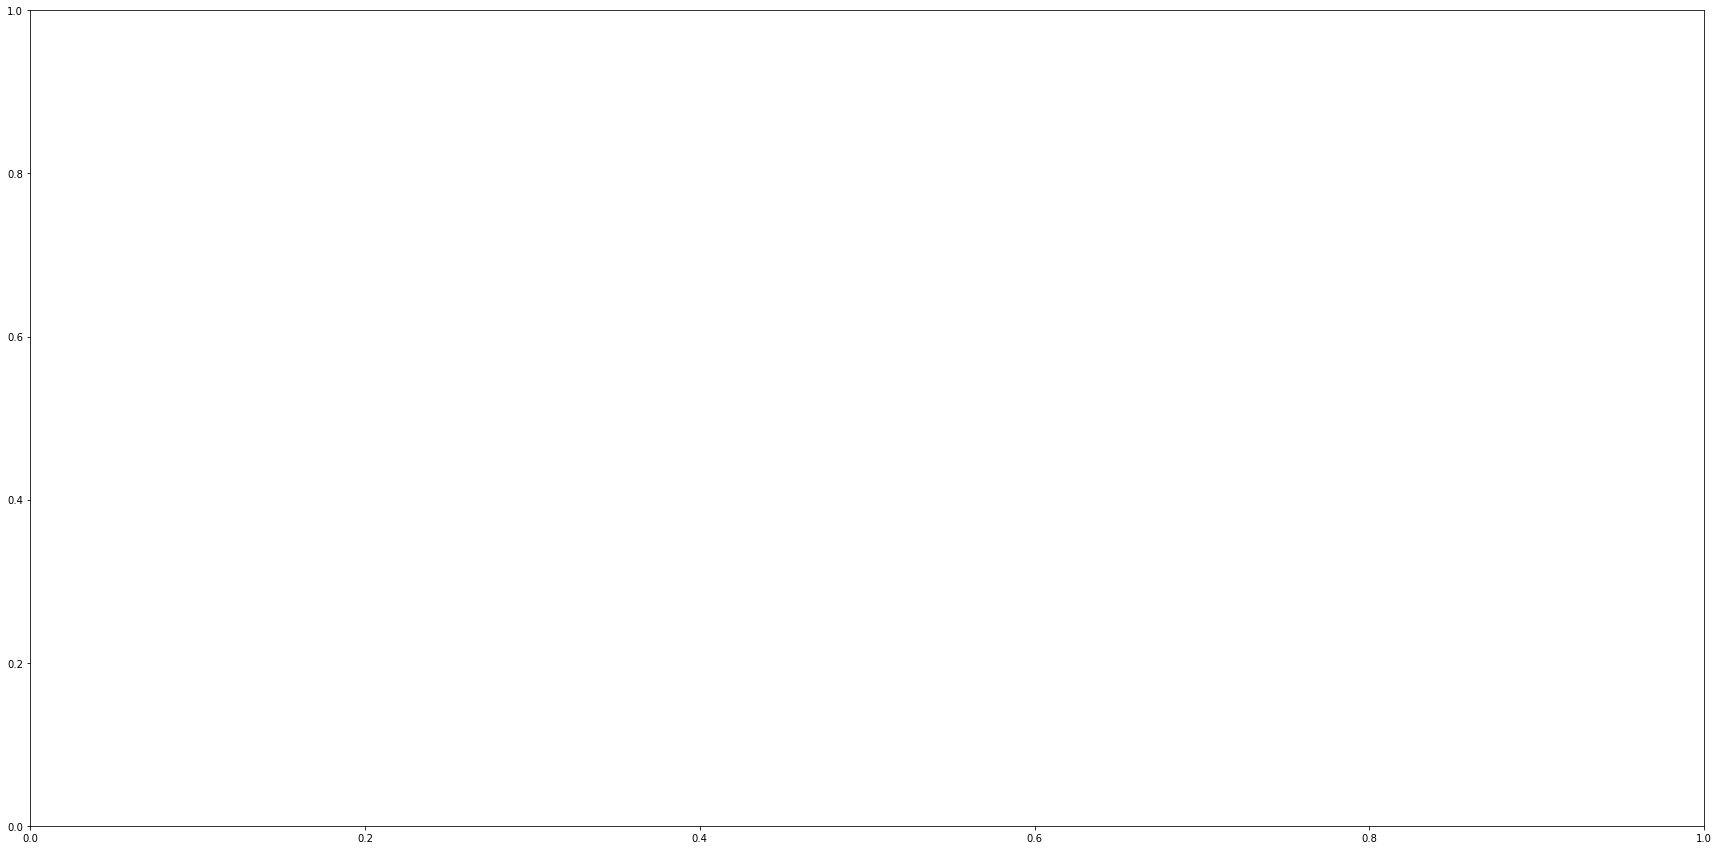

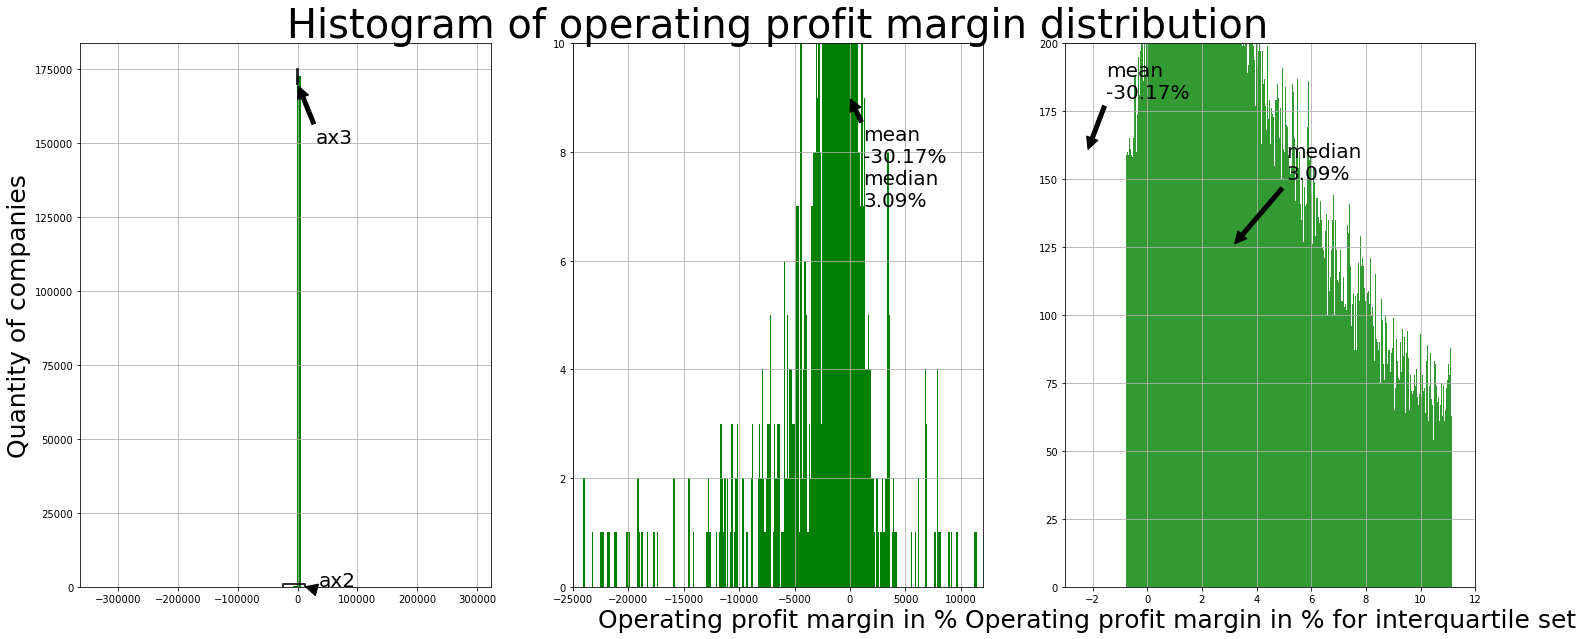

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10), sharey = False)
#plt.figure(figsize=(15,10))

ax1.hist(clean_data.opm, 100, facecolor = 'g', alpha = 1)
ax1.plot((-25000,-25000,12000,12000),(0,1000,1000,0), color = 'black', linewidth = 2, alpha = 0.8)
ax1.plot((-1000,-1000,1200,1200,-1000),(170000,175000,175000,170000,170000), color = 'black', linewidth = 2, alpha = 0.8)
ax2.hist(clean_data.opm, 5000, facecolor = 'g', alpha = 0.8)
#plt.axis([-10000,10000,0,500])
ax2.set_xlim(left = -25000,right = 12000)
ax2.set_ylim(bottom = 0,top =  10)
ax3.hist(dis_25_75, 500, facecolor = 'g', alpha = 0.5)
ax3.set_ylim(bottom = 0, top = 200)
ax3.set_xlim(left = -3, right = 12)
ax2.set_title('Histogram of operating profit margin distribution', fontsize = 40)
for x in [ax1, ax2, ax3]:
    x.grid()
ax2.set_xlabel('Operating profit margin in %', fontsize = 25)
ax3.set_xlabel('Operating profit margin in % for interquartile set', fontsize = 25)
ax1.set_ylabel('Quantity of companies', fontsize = 25)    
ax2.annotate('mean\n'+str(round(dis_mean, 2))+'%\nmedian\n'+str(round(dis_median,2))+'%', xy = (dis_mean, 9), \
             xytext=(dis_mean+1200, 7), fontsize = 20, arrowprops=dict(facecolor='black', shrink=0.05),)
ax3.annotate('median\n'+str(round(dis_median,2))+'%', xy = (dis_median, 125), xytext=(dis_median+2, 150), fontsize = 20,\
             arrowprops=dict(facecolor='black', shrink=0.05),)
ax3.annotate('mean\n'+str(round(dis_mean, 2))+'%', xy = (-2.2, 160), \
             xytext=(-1.5, 180), fontsize = 20, arrowprops=dict(facecolor='black', shrink=0.05),)
ax1.annotate('ax2', xy = (12000, 125), xytext=(35000, 150), fontsize = 20,\
             arrowprops=dict(facecolor='black', shrink=0.05),)
ax1.annotate('ax3', xy = (20, 170000), xytext=(30000, 150000), fontsize = 20,\
             arrowprops=dict(facecolor='black', shrink=0.05),)
    
plt.show()

## Dependence of operating margin from revenue

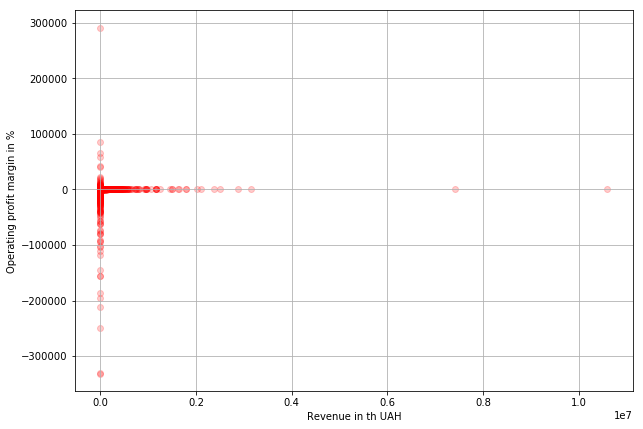

In [69]:
plt.figure(figsize=(10,7))
plt.scatter(clean_data['rev_mean'], clean_data['opm'], c = 'r', alpha=0.2)
plt.xlabel('Revenue in th UAH')
plt.ylabel('Operating profit margin in %')
plt.grid()
plt.show()

In [70]:
#rounding revenue figure to the nearest mln
#cutting off outliers with operating profit margin greater than 10000% or less than -10000%

opm_from_rev = clean_data.loc[:,['rev_mean', 'pnl_meam','opm','quantity']]

opm_from_rev['rev_mean'] = opm_from_rev['rev_mean'].round(decimals = -3)/1000
opm_from_rev1 = opm_from_rev[opm_from_rev.opm>-10000.0]
opm_from_rev2 = opm_from_rev1[opm_from_rev1.opm<10000.0]
opm_from_rev_g = opm_from_rev2.groupby(['rev_mean'], as_index = False).agg({'quantity' : np.sum,'opm' : np.median})
opm_from_rev_g_mean = opm_from_rev2.groupby(['rev_mean'], as_index = False).agg({'quantity' : np.sum,'opm' : np.mean})

In [71]:
 opm_from_rev2.shape

(172961, 4)

In [72]:
opm_from_rev_g.describe()

,rev_mean,quantity,opm
count,346.000000,346.000000,346.000000
mean,346.086705,499.887283,2.219364
std,790.087262,5281.844632,7.453460
min,0.000000,1.000000,-34.270811
25%,86.250000,1.000000,0.650802
50%,177.500000,2.000000,1.772558
75%,325.250000,12.000000,2.895217
max,10601.000000,90124.000000,110.576447


## Using linear regression to determine the trend

In [73]:
lr = linear_model.LinearRegression()

rev_train = opm_from_rev_g.loc[:,['rev_mean']]
opm_train = opm_from_rev_g.loc[:,['opm']]
rev_test = opm_from_rev_g.loc[:,['rev_mean']]

lr.fit(rev_train, opm_train)
pred = lr.predict(rev_test)

In [74]:
last = len(pred)-1
pred[last], opm_from_rev_g.rev_mean[last]

(array([ 1.66515092]), 10601.0)

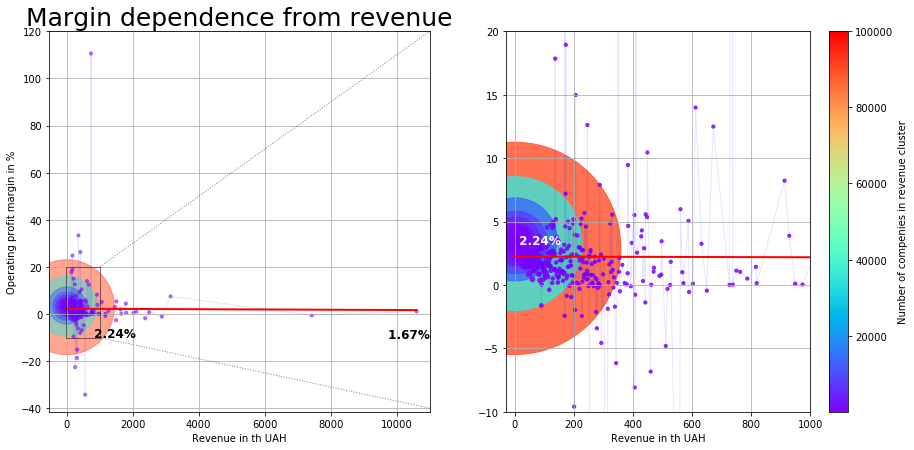

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,7), sharey = False)

cmap = plt.cm.rainbow
#norm = mpl.colors.Normalize(vmin = opm_from_rev_g.quantity.min(), vmax = opm_from_rev_g.quantity.max())
norm = mpl.colors.Normalize(vmin = 1, vmax = 100000)
ax2.scatter(opm_from_rev_g['rev_mean'], opm_from_rev_g['opm'], s = 10+opm_from_rev_g.quantity/2,\
            c = cmap(norm(opm_from_rev_g.quantity)), alpha=0.8)

ax1.scatter(opm_from_rev_g['rev_mean'], opm_from_rev_g['opm'], s = 10+opm_from_rev_g.quantity/10,\
            c = cmap(norm(opm_from_rev_g.quantity)), alpha=0.5)
ax2.set_xlim(left = -30, right = 1000)
ax2.set_ylim(bottom = -10, top = 20)
ax1.set_xlim(right = 11000)
ax1.set_ylim(top = 120)
for x in [ax1, ax2]:
    x.set_xlabel('Revenue in th UAH')
    ax1.set_ylabel('Operating profit margin in %')
    x.grid()
    x.plot(opm_from_rev_g.rev_mean, opm_from_rev_g.opm, color = 'b', linewidth=1, alpha=0.1)
    x.plot(opm_from_rev_g.rev_mean, pred, color = 'r', linewidth=2, alpha=1)
ax1.annotate(str(pred[0].round(decimals=2))[1:-1]+'%', (opm_from_rev_g.rev_mean[0]+700, pred[0]-12),fontsize = 12,color = 'black',\
              weight = 'bold')
ax2.annotate(str(pred[0].round(decimals=2))[1:-1]+'%', (opm_from_rev_g.rev_mean[0], pred[0]+1),fontsize = 12,color = 'white',\
              weight = 'bold')
ax1.annotate(str(pred[last].round(decimals=2))[1:-1]+'%', (opm_from_rev_g.rev_mean[last]-1000, pred[last]-12),fontsize = 12,\
             color = 'black', weight = 'bold')
ax1.plot((-30,1000,1000,-30,-30), (20,20,-10,-10,20), color = 'black', linewidth=1, alpha=0.5)
ax1.plot((1000, 11000),(20,120), color = 'black',linewidth=1, alpha=0.5, linestyle = ':')
ax1.plot((1000, 11000),(-10,-40), color = 'black',linewidth=1, alpha=0.5, linestyle = ':')
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
fig.colorbar(sm).set_label('Number of compenies in revenue cluster', rotation=90)
ax1.set_title('Margin dependence from revenue').set_fontsize(25)
plt.show()

## Margin dependence from geography

In [76]:
regions_ll = pd.DataFrame({'region': ['вінницька', 'волинська', 'дніпропетровська', 'донецька', 'житомирська', 'закарпатська', \
                                      'запорізька', 'івано-франківська', 'київська', 'кіровоградська','луганська', 'львівська', \
                                      'миколаївська', 'одеська', 'полтавська', 'рівенська', 'сумська', 'тернопільська',\
                                      'харківська', 'херсонська', 'хмельницька', 'черкаська', 'чернігівська', 'чернівецька'], 
                        'city': ['вінниця', 'луцьк', 'дніпро', 'донецьк', 'житомир', 'ужгород',\
                                 'запоріжжя', 'івано-франківськ', 'киев', 'кропивницький', 'луганськ', 'львів', \
                                 'миколаїв', 'одеса', 'полтава', 'рівне', 'суми', 'тернопіль',\
                                 'харків', 'херсон', 'хмельницький', 'черкаси', 'чернігів', 'чернівці'],
                       'latitude':[49.14,    50.45,   48.28,    48.00,     50.15,    48.37,\
                                   47.50,    48.55,   50.27,    48.30,     48.35,    49.50, \
                                   46.58,    46.29,   49.34,    50.37,     50.54,    49.34, \
                                   50.00,    46.38,   49.25,    49.26,     51.30,    48.17],
                       'longtitude':[28.28,  25.19,   35.01,    37.48,     28.39,    22.37,\
                                     35.08,  24.42,   30.31,    32.16,     39.20,    24.00, \
                                     32.00,  30.43,   34.34,    26.15,     34.48,    26.36,\
                                     36.13,  32.36,   27.00,    32.03,     31.18,    25.56]})

In [77]:
def get_region(x):
    x = str(x).lower()
    temp = re.findall(r',\s(\S+)\sобл.', x)
    try: return temp[0]
    except IndexError: return np.nan
    
def rename_city(df):
    df.city[df['city']=='Дніпро (Дніпропетровськ)']='Дніпро'
    df.city[df['city']=='Дніпропетровськ']='Дніпро'
    df.city[df['city']=='Камьянське (Дніпродзержинськ)'] = 'Камьянське'
    df.city[df['city']=='Дніпродзержинськ'] = 'Камьянське'
    df.city[df['city']=='Кропивницький (Кіровоград)'] = 'Кропивницький'
    df.city[df['city']=='Кіровоград'] = 'Кропивницький'
    df.city = [str(x).lower() for x in  df.city]
    return df    

In [78]:
temp = clean_data.loc[:,['city', 'adress', 'pnl_mean','opm','quantity']]
temp = rename_city(temp)
opm_from_geo = pd.merge(temp,regions_ll.loc[:,['city','region']], how ='left', on = 'city')

opm_from_geo.region[opm_from_geo.region.isnull()] = opm_from_geo.adress.apply(lambda x: get_region(x))
#opm_from_geo.head(10)

C:\Users\1\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\1\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\1\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\1\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [79]:
opm_from_city_g = opm_from_geo.loc[:,['city', 'opm', 'quantity']].groupby(by='city', axis = 0, as_index = False).\
agg({'quantity' : np.sum,'opm' : np.median}).sort_values(by = 'quantity', axis = 0, ascending = False)
opm_from_city_g = opm_from_city_g[opm_from_city_g.quantity>=200].dropna(subset = ['city'], axis = 0)
opm_from_city_g = opm_from_city_g[opm_from_city_g.city!='nan']
opm_from_city_g['city_id'] = np.arange(1,len(opm_from_city_g.index)+1)

In [80]:
opm_from_city_g.describe()

,quantity,opm,city_id
count,62.000000,62.000000,62.000000
mean,1842.290323,2.658625,31.500000
std,4973.343077,1.234756,18.041619
min,200.000000,0.544387,1.000000
25%,244.250000,2.068443,16.250000
50%,501.500000,2.398906,31.500000
75%,1548.750000,2.934002,46.750000
max,37728.000000,9.090909,62.000000


In [81]:
annotations = opm_from_city_g.city.values
x = opm_from_city_g.city_id.values
y = opm_from_city_g.opm.values
range_median = np.linspace(dis_median, dis_median, len(annotations))

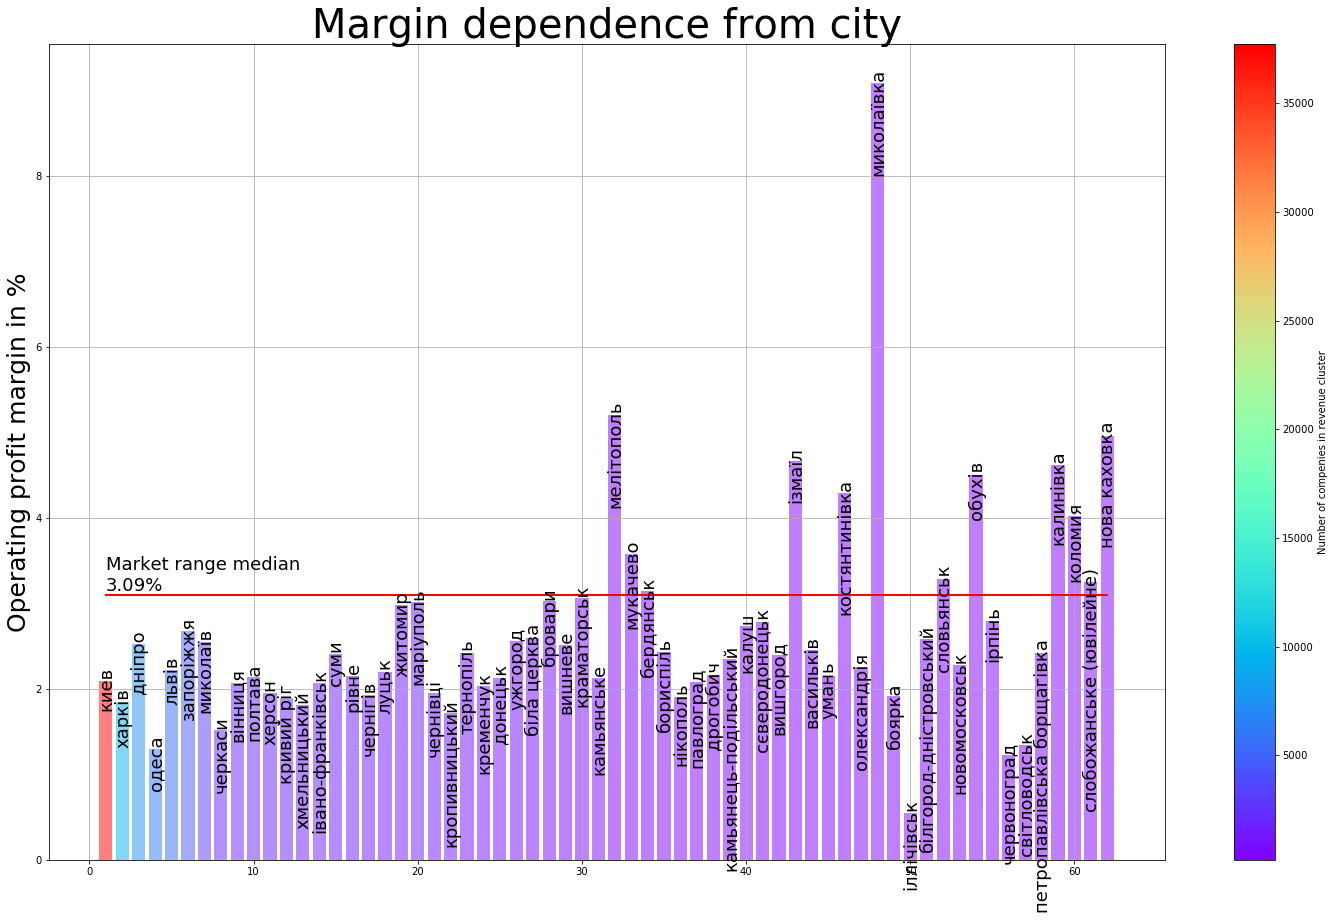

In [82]:
fig, ax = plt.subplots(figsize=(25,15))


cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin = opm_from_city_g.quantity.min(), vmax = opm_from_city_g.quantity.max())
#norm = mpl.colors.Normalize(vmin = 1, vmax = 100000)
ax.bar(x, y, color = cmap(norm(opm_from_city_g.quantity)), alpha = 0.5)
ax.plot(x, range_median, color = 'r', linewidth=2, alpha=1)
ax.set_title('Margin dependence from city')
ax.title.set_fontsize(40)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(25)
for i in range(len(annotations)):
    ax.annotate(annotations[i], (x[i]-0.5,y[i]), fontsize = 18, rotation = 90)   
    #ax.annotate(annotations_opm_year[i], (x_year[i], y_year[i]+0.1), fontsize = 12)
ax.annotate('Market range median\n'+str(round(dis_median,2))+'%', xy=(1,3.15), fontsize = 18)
#ax.set_xlabel('City_id')
ax.set_ylabel('Operating profit margin in %')
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
fig.colorbar(sm).set_label('Number of compenies in revenue cluster', rotation=90, fontsize = 18)
plt.grid()
plt.show()

In [83]:
opm_from_reg_g_temp = opm_from_geo.loc[:,['region', 'opm', 'quantity']].dropna(subset = ['region'], axis = 0)

In [84]:
def return_correct_region(x):
    if str(x).startswith('льв'):return 'львівська'
    elif str(x).startswith('киъ') or str(x).startswith('кие') or str(x).startswith('киї'):return 'київська'
    elif str(x).startswith('дне') or str(x).startswith('дн'):return 'дніпропетровська'
    elif str(x).startswith('вол'):return 'волинська'
    elif str(x).startswith('іван') or str(x).startswith('иван') or str(x).startswith('iван'):return 'івано-франківська'
    elif str(x).startswith('одес'):return 'одеська'
    elif str(x).startswith('хар'):return 'харківська'
    elif str(x).startswith('ров') or str(x).startswith('рі') or str(x).startswith('рiв'):return 'рівенська'
    elif str(x).startswith('закар'):return 'закарпатська'
    elif str(x).startswith('сум'):return 'сумська'
    elif str(x).startswith('жит'):return 'житомирська'
    elif str(x).startswith('хер'):return 'херсонська'
    elif str(x).startswith('черк'):return 'черкаська'
    elif str(x).startswith('черніг') or str(x).startswith('черниг') or str(x).startswith('чернiг'):return 'чернігівська'
    elif str(x).startswith('чернів') or str(x).startswith('чернив') or str(x).startswith('черныв'):return 'чернівецька'
    elif str(x).startswith('дон'):return 'донецька'
    elif str(x).startswith('луг'):return 'луганська'
    elif str(x).startswith('терн'):return 'тернопільська'
    elif str(x).startswith('пол'):return 'полтавська'
    elif str(x).startswith('вин') or str(x).startswith('він') or str(x).startswith('вiн') :return 'вінницька'
    elif str(x).startswith('кир') or str(x).startswith('кір')or str(x).startswith('кiр'):return 'кіровоградська'
    elif str(x).startswith('хме'):return 'хмельницька'
    elif str(x).startswith('хме'):return 'хмельницька'
    elif str(x).startswith('зап') or str(x).startswith('зіп') or str(x).startswith('жап'):return 'запорізька'
    else: return x

opm_from_reg_g_temp.region = opm_from_reg_g_temp.region.apply(lambda x: return_correct_region(x))
opm_from_reg_g_temp = opm_from_reg_g_temp[opm_from_reg_g_temp.region != 'вул.']

In [85]:
opm_from_reg_g = pd.merge(opm_from_reg_g_temp, regions_ll, on = 'region', how = 'left')
#opm_from_reg_g.region.describe()

In [86]:
opm_from_reg_g = opm_from_reg_g.groupby(by='region', axis = 0, as_index = False).agg({'quantity' : np.sum,'opm' : np.median,\
                                                                                     'latitude': np.median,\
                                                                                      'longtitude':np.median}).\
sort_values(by = 'quantity', axis = 0, ascending = False)

In [87]:
opm_from_reg_g['opm'] = opm_from_reg_g['opm'].apply(lambda x: np.around(x, decimals = 2))
annotations_reg = opm_from_reg_g['region'].values
annotations_opm = opm_from_reg_g['opm'].values
x_reg = opm_from_reg_g['longtitude'].values
y_reg = opm_from_reg_g['latitude'].values

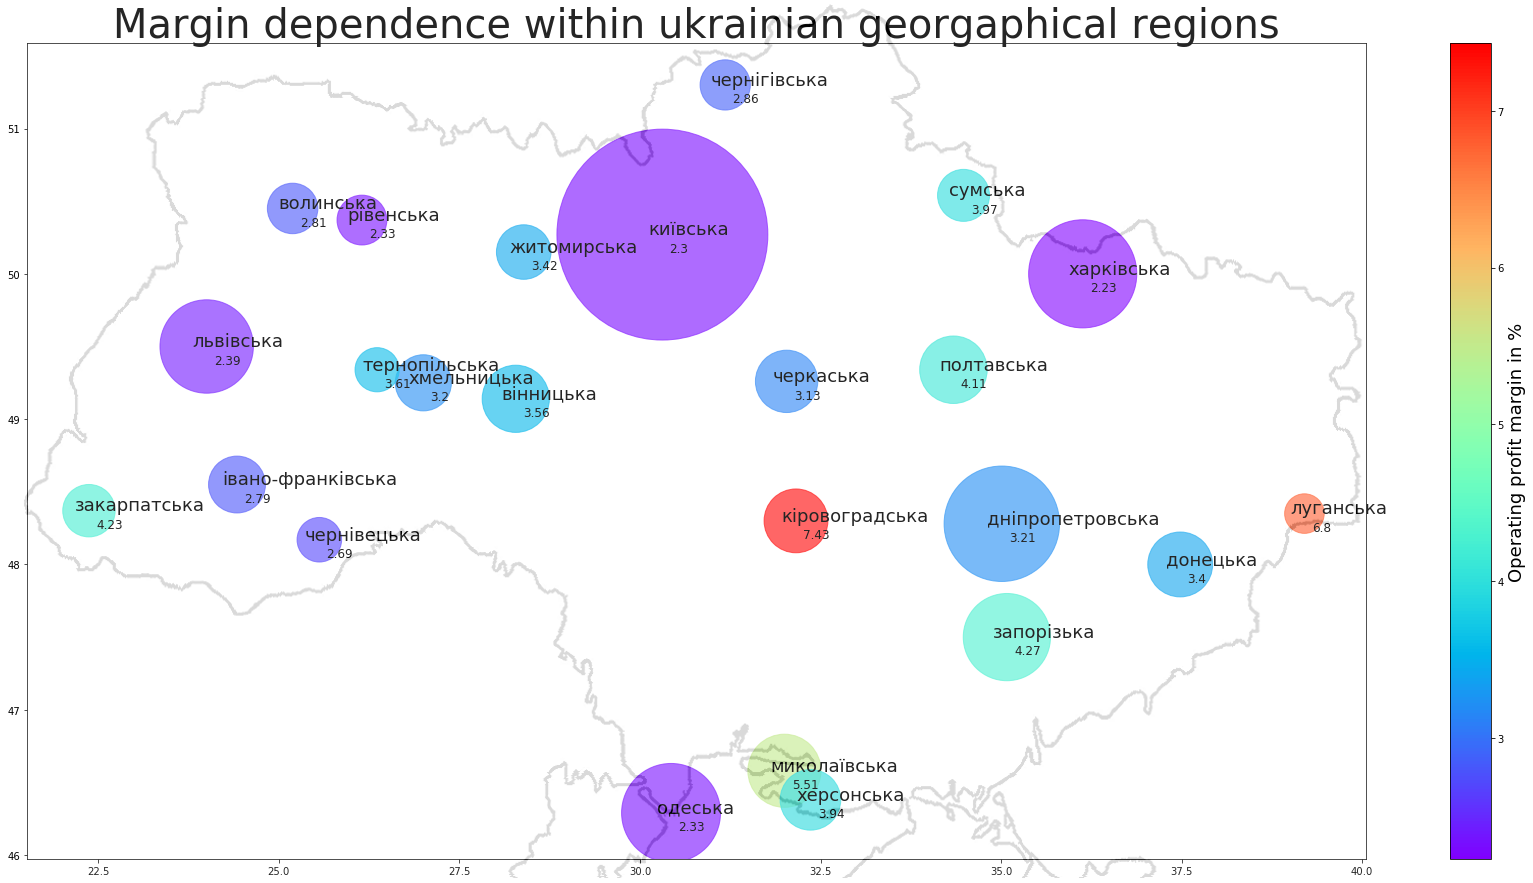

In [127]:
datafile = cbook.get_sample_data(r'C:\Users\1\Pictures\Saved Pictures\Blank_map_of_Ukraine_copy(2).png', asfileobj=False)
#print('loading %s' % datafile)
im = image.imread(datafile)

im[:, :, -1] = 0.3  # set the alpha channel

fig, ax = plt.subplots(figsize=(30,15))
#plt.figure(figsize=(30,15))
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin = opm_from_reg_g['opm'].min(), vmax = opm_from_reg_g['opm'].max())

ax.scatter(opm_from_reg_g['longtitude'], opm_from_reg_g['latitude'], s = opm_from_reg_g.quantity,\
           c =cmap(norm(opm_from_reg_g.opm)), alpha = 0.7)
ax.set_title('Margin dependence within ukrainian georgaphical regions')
#plt.imshow(fd_reg['opm'], cmap = cm.afmhot)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
cbar = fig.colorbar(sm).set_label('Operating profit margin in %', fontsize = 18)
#cbar.ax.set_yticklabels(fontsize = 12)
fig.figimage(im, zorder=10, xo=20, yo=5, alpha=.5)


for i in range(len(annotations_reg)):
    ax.annotate(annotations_reg[i], (x_reg[i]-0.2, y_reg[i]), fontsize = 18)   
    ax.annotate(annotations_opm[i], (x_reg[i]+0.1, y_reg[i]-0.12), fontsize = 12)
#plt.annotate(xy = (fd_city['city_id'], fd_city['opm']), s = fd_city['city'])
#plt.legend(handles=[list(fd_city['city'].values())], loc=1)
#ax = plt.subplot(111, xlabel='x', ylabel='y', title='title')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(40)
plt.show()

## Margin dependence from year of incorporation 

In [128]:
opm_from_year = clean_data.loc[:,['opm', 'quantity', 'inc_year']]
opm_from_year['no_y_from_inc'] = opm_from_year.inc_year.apply(lambda x: 2015 - x)
opm_from_year_g = opm_from_year.groupby(by = 'no_y_from_inc', as_index = False, axis = 0).\
agg({'inc_year':np.median, 'opm': np.median, 'quantity':np.sum}).\
sort_values(by='no_y_from_inc', ascending = True, axis=0).dropna(subset = ['no_y_from_inc'], axis = 0)
opm_from_year_g.describe()

,no_y_from_inc,inc_year,quantity,opm
count,68.000000,68.000000,68.000000,68.000000
mean,46.382353,1968.617647,1865.955882,-1.741920
std,45.569049,45.569049,3462.715665,40.467469
min,0.000000,1701.000000,1.000000,-315.191239
25%,16.750000,1948.750000,1.750000,-0.076794
50%,39.500000,1975.500000,3.500000,2.474291
75%,66.250000,1998.250000,1536.500000,4.082422
max,314.000000,2015.000000,14454.000000,58.570794


In [129]:
lr_y = linear_model.LinearRegression()

year_train = opm_from_year_g.loc[:,['no_y_from_inc']]
opm_train = opm_from_year_g.loc[:,['opm']]
year_test = opm_from_year_g.loc[:,['no_y_from_inc']]

year_train2 = opm_from_year_g.loc[:28,['no_y_from_inc']]
opm_train2 = opm_from_year_g.loc[:28,['opm']]
year_test2 = opm_from_year_g.loc[:28,['no_y_from_inc']]

lr_y.fit(year_train, opm_train)
pred = lr_y.predict(year_test)

lr_y.fit(year_train2, opm_train2)
pred2 = lr_y.predict(year_test2)


In [130]:
opm_from_year_g['inc_year'] = opm_from_year_g['inc_year'].apply(lambda x: str(x)[:-2])
opm_from_year_g['opm'] = opm_from_year_g['opm'].apply(lambda x: np.around(x, decimals = 2))
annotations_year = opm_from_year_g['inc_year'].values
annotations_opm_year = opm_from_year_g['opm'].values
x_year = opm_from_year_g['no_y_from_inc'].values
y_year = opm_from_year_g['opm'].values

startups = opm_from_year_g.loc[:5,['no_y_from_inc']].values
startups_opm = opm_from_year_g.loc[:5,['opm']].values

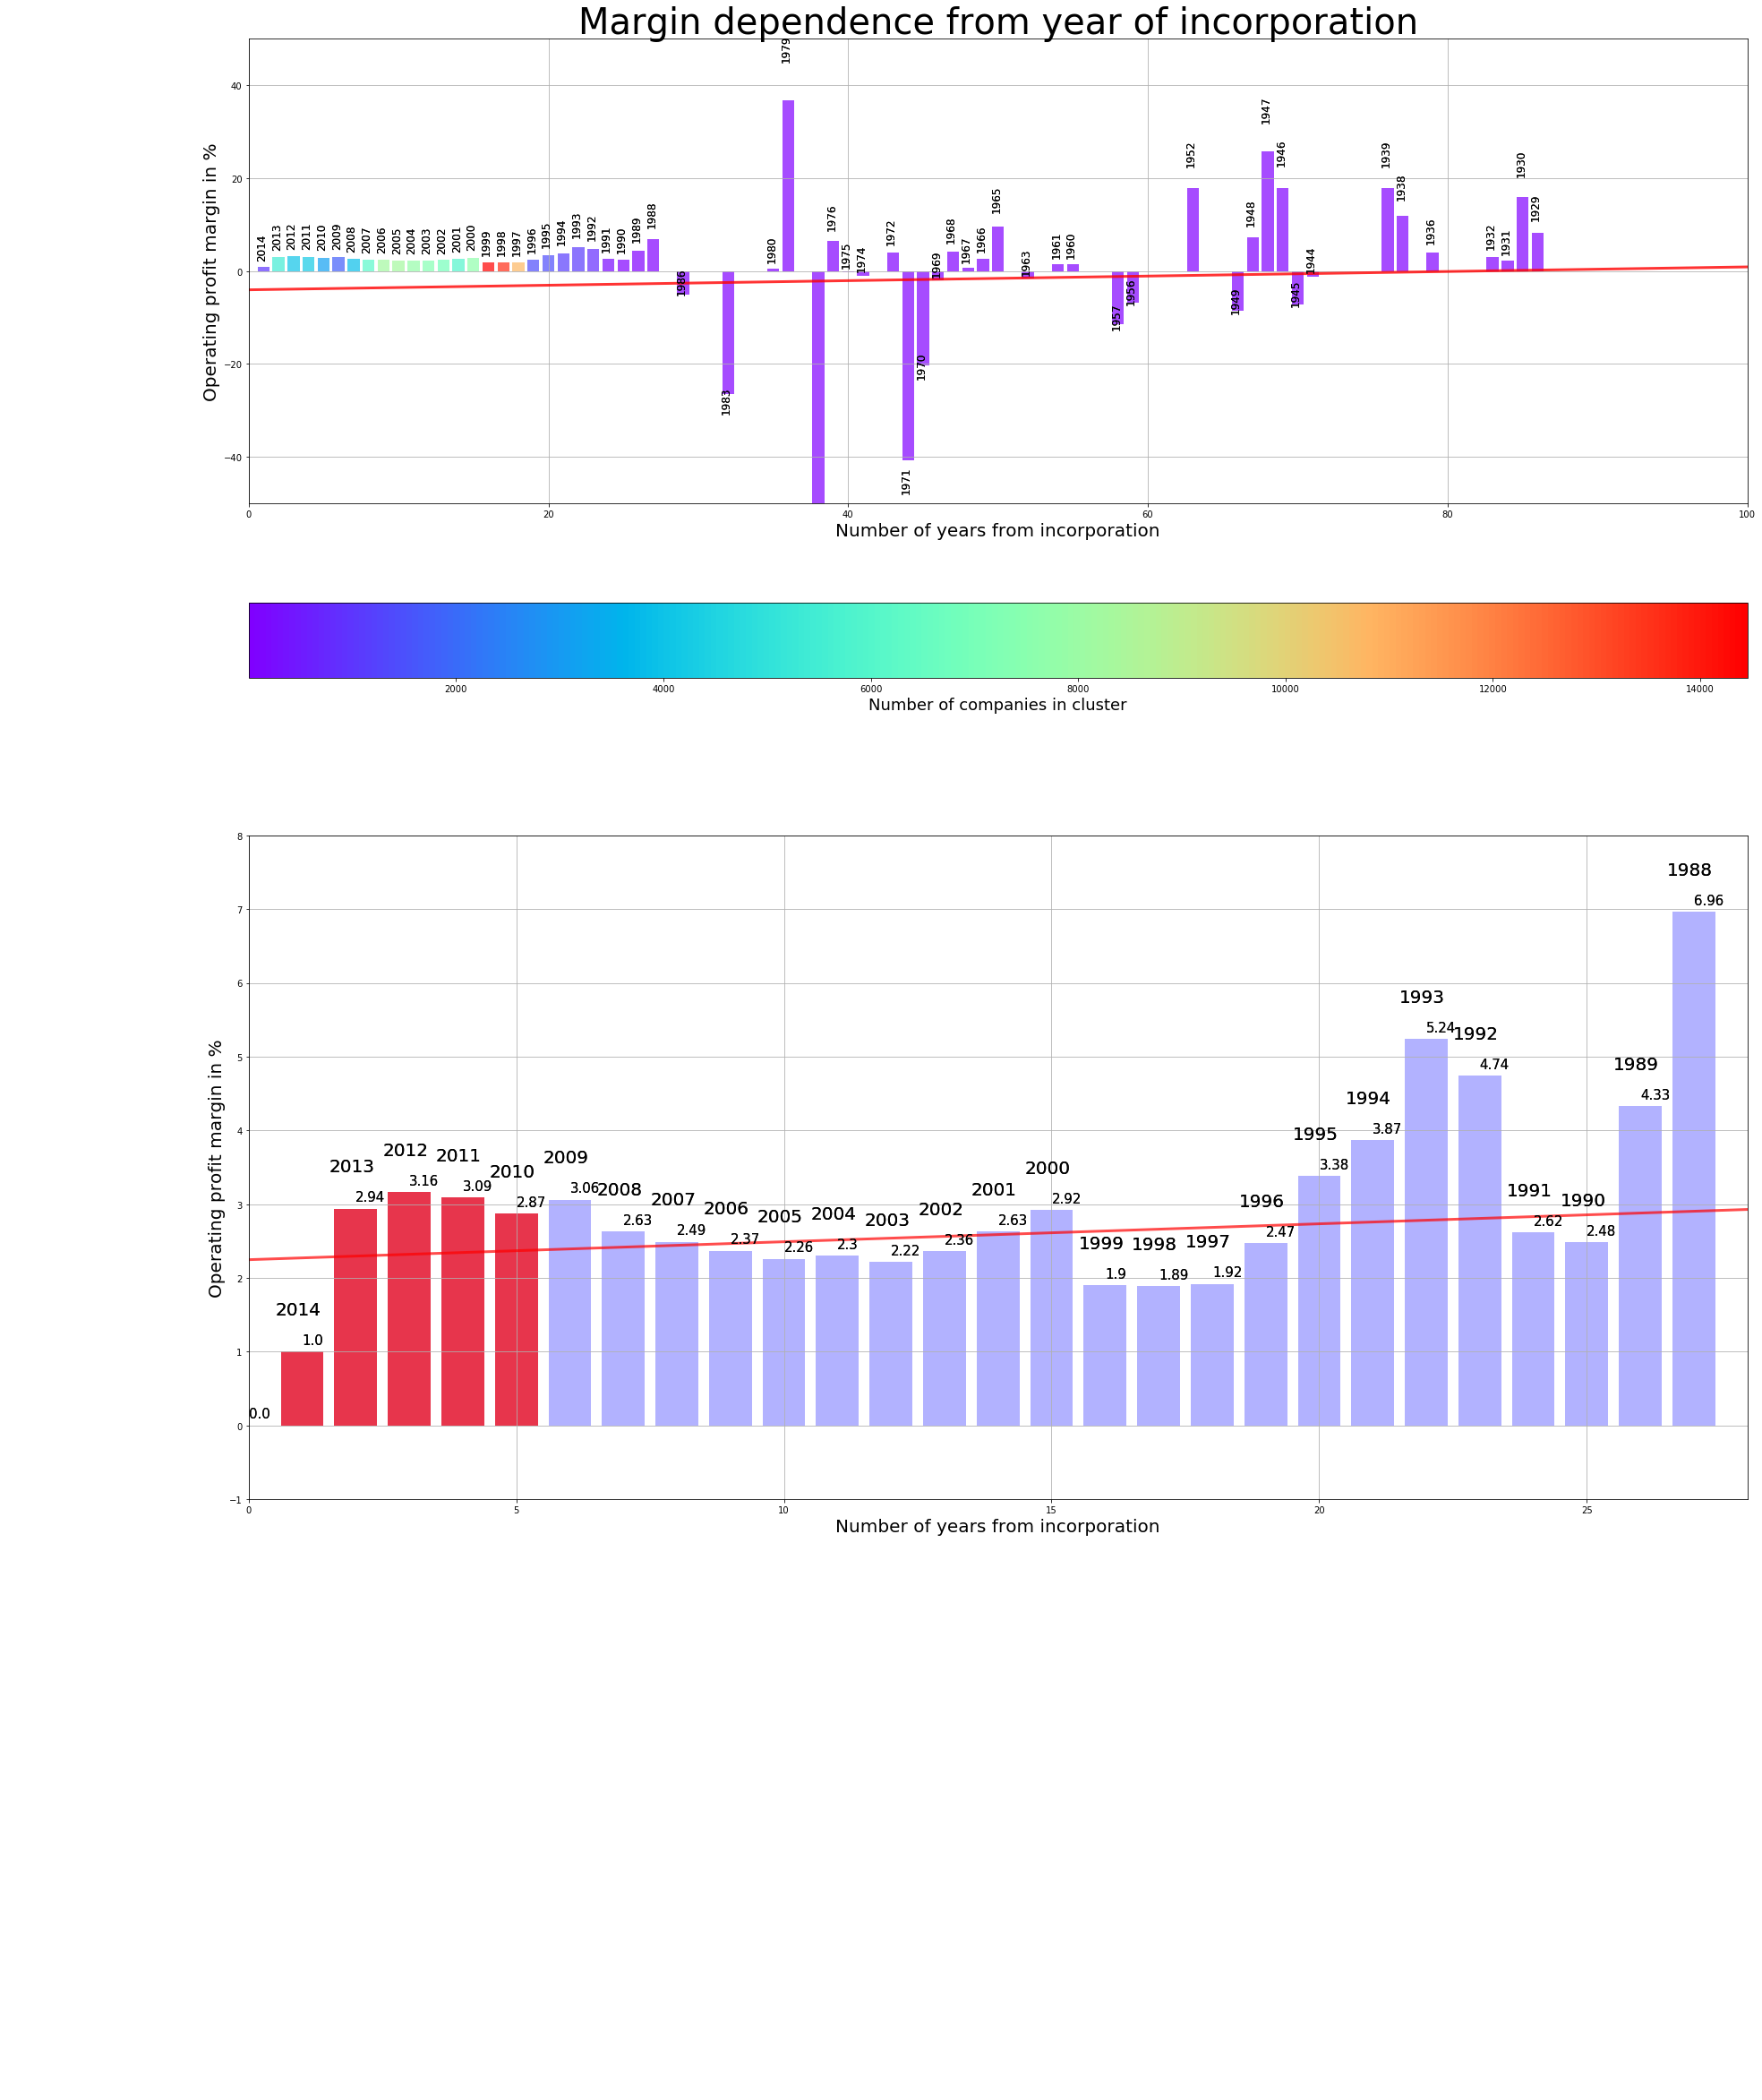

In [131]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,30))
#plt.figure(figsize=(25,10))
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin = opm_from_year_g.quantity.min(), vmax = opm_from_year_g.quantity.max())

ax1 = plt.subplot(2,1,1)
ax1.bar(opm_from_year_g['no_y_from_inc'], opm_from_year_g['opm'], color=cmap(norm(opm_from_year_g.quantity)), alpha=0.7)
#ax1.bar(startups, startups_opm, color='r', alpha=0.7)
ax1.plot(year_test, pred, color='r', linewidth=3, alpha=0.8)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
cbar = fig.colorbar(sm,  orientation='horizontal').set_label('Number of companies in cluster', fontsize = 18)

ax2 = plt.subplot(2,1,2)

ax2.bar(opm_from_year_g['no_y_from_inc'], opm_from_year_g['opm'], color='b', alpha=0.3)
ax2.bar(startups, startups_opm, color='r', alpha=0.7)
ax2.plot(year_test2, pred2, color='r', linewidth=3, alpha=0.7)
ax1.set_xlim(left = 0, right = 100)
ax1.set_ylim(bottom = -50, top = 50)

ax1.set_title('Margin dependence from year of incorporation', fontsize = 40)
ax.title.set_fontsize(40)
ax2.set_xlim(left = 0, right = 28)
ax2.set_ylim(bottom = -1, top = 8)


for ax in [ax1,ax2]:
    ax.grid()
    ax.set_ylabel('Operating profit margin in %', fontsize = 20)
    ax.set_xlabel('Number of years from incorporation', fontsize = 20)
    #ax.set_xticklabels(opm_from_year_g['no_y_from_inc'],fontsize = 20)
    #ax.set_yticklabels(opm_from_year_g['opm'],fontsize = 20)
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(20)
    for i in range(len(annotations_year)):
        ax1.annotate(annotations_year[i], (x_year[i]-0.5, y_year[i]*1.2+5), fontsize = 12, rotation = 90) 
        ax2.annotate(annotations_year[i], (x_year[i]-0.5, y_year[i]+0.5), fontsize = 20)
        ax2.annotate(annotations_opm_year[i], (x_year[i], y_year[i]+0.1), fontsize = 15)

plt.show()

## Dependence from Nace Rev.2. code

In [171]:
def correct_nace(x):
    if len(x)<2:
        x = x.replace(x,'0'+x)
    else: x = x
    return x

In [311]:
opm_from_nace = clean_data.loc[:,['opm', 'quantity', 'nace']].dropna(subset = ['nace'], axis = 0)
opm_from_nace.nace=opm_from_nace.nace.apply(lambda x: str(round(x,0)))
opm_from_nace['div'] = [int(x[:-4]) for x in opm_from_nace.nace]
#opm_from_nace['div'] = [correct_nace(x) for x in opm_from_nace['div']]

In [275]:
nace = open(r'nace.txt', 'r').read()
nace

'Section Title Divisions\nA Agriculture, forestry and fishing 01 - 03\nB Mining and quarrying 05 - 09\nC Manufacturing 10 - 33\nD Electricity, gas, steam and air conditioning supply 35\nE Water supply; sewerage, waste management and remediation activities 36 - 39\nF Construction 41 – 43\nG Wholesale and retail trade; repair of motor vehicles and motorcycles 45 - 47\nH Transportation and storage 49 - 53\nI Accommodation and food service activities 55 - 56\nJ Information and communication 58 - 63\nK Financial and insurance activities 64 - 66\nL Real estate activities 68\nM Professional, scientific and technical activities 69 - 75\nN Administrative and support service activities 77 - 82\nO Public administration and defence; compulsory social security 84\nP Education 85\nQ Human health and social work activities 86 - 88\nR Arts, entertainment and recreation 90 - 93\nS Other service activities 94 - 96\nT Activities of households as employers; undifferentiated goods- and services-producing a

In [280]:
section = []
desc = []
divs = []
#nace = nace.split('\n')
for line in nace:
    [section.append(x[0]) for x in re.findall(r'[A-Z] ', line) if x!=[]]
    [desc.append(x) for x in re.findall(r' ([A-Za-z\s,;]+) \d', line, flags=re.IGNORECASE) if x!=[]]
    if re.findall(r'\d{2}', line, flags=re.IGNORECASE)!=[]:
        divs.append(re.findall(r'\d{2}', line, flags=re.IGNORECASE)) 
   

In [286]:
divs2 = []
for line in divs:
    line2 = []
    for div in line:
        line2.append(int(div))
    line2 = tuple(line2)
    divs2.append(line2)
len(divs2)    

21

In [356]:
pieces = []
for i in range(0,len(divs2)):
    if len(divs2[i])==2:
        divs3 = np.arange(divs2[i][0],divs2[i][1]+1)
    else: divs3 = [divs2[i][0]]   
    nace_divs = pd.DataFrame({'section': pd.Series([section[i]]*len(divs3)),
                              'description': pd.Series([desc[i]]*len(divs3)),
                              'div': pd.Series(divs3)})
    pieces.append(nace_divs)
full_nace_divs = pd.concat(pieces, ignore_index = True)
opm_from_nace_g = pd.merge(opm_from_nace, full_nace_divs, on = 'div', how = 'left').\
groupby(by=['section','description'], as_index = False).agg({'opm': np.median, 'quantity': np.sum}).\
sort_values(by=['quantity'], ascending = True)
opm_from_nace_g

,section,description,quantity,opm
14,O,Public administration and defence; compulsory ...,21,3.849760
1,B,Mining and quarrying,310,1.541834
3,D,"Electricity, gas, steam and air conditioning s...",343,1.181674
17,R,"Arts, entertainment and recreation",663,-2.258434
10,K,Financial and insurance activities,692,2.879511
4,E,"Water supply; sewerage, waste management and r...",848,1.947321
15,P,Education,1009,3.977273
18,S,Other service activities,2274,0.952608
16,Q,Human health and social work activities,2579,1.391179
8,I,Accommodation and food service activities,3724,-0.030022


In [440]:
labels = []
[labels.append(x+' '+y+'-'+str(round(z,2))+'%') for x, y, z in zip(opm_from_nace_g.section, opm_from_nace_g.description,\
                                                                   opm_from_nace_g.opm)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [423]:
N = len(opm_from_nace_g.index)
theta = np.arange(0.0, 3*np.pi, 3*np.pi/N)
radii = opm_from_nace_g.opm
width = np.pi*opm_from_nace_g.quantity/200000
theta

array([ 0.        ,  0.49604095,  0.99208189,  1.48812284,  1.98416378,
        2.48020473,  2.97624567,  3.47228662,  3.96832756,  4.46436851,
        4.96040945,  5.4564504 ,  5.95249134,  6.44853229,  6.94457323,
        7.44061418,  7.93665512,  8.43269607,  8.92873702])

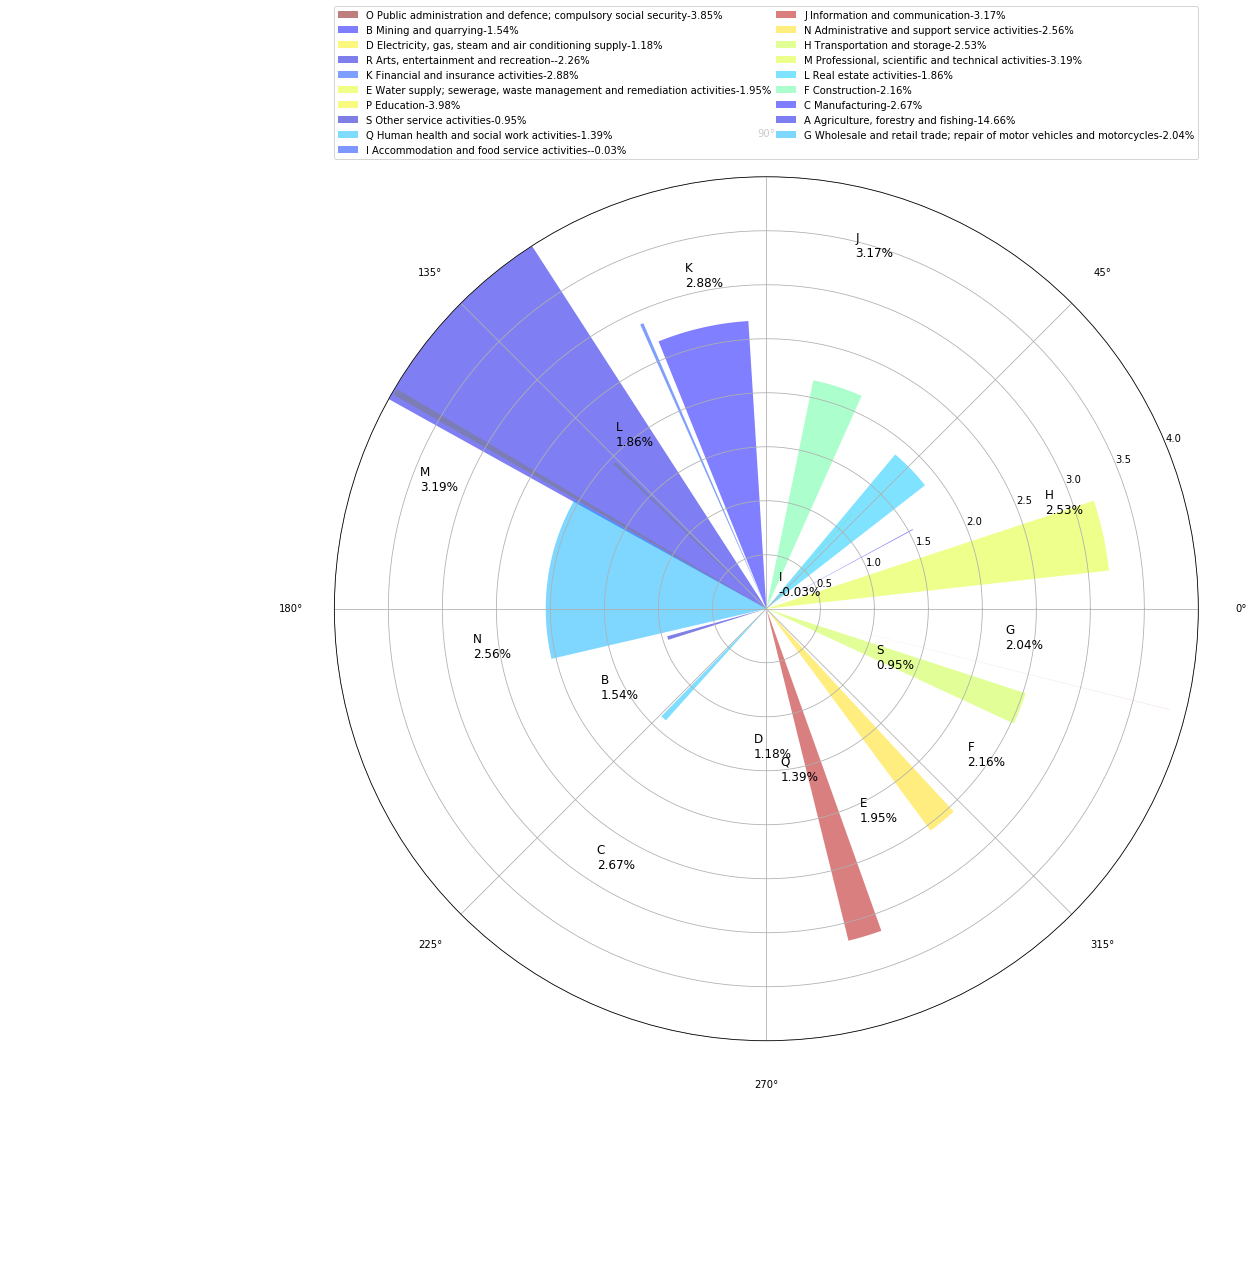

In [443]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc

# force square figure and square axes looks better for polar, IMO
fig = figure(figsize=(30,15))
ax = fig.add_axes([0.1, 0.2, 0.5, 0.8], polar=True)
ax.set_ylim(0.0, 4)



bars = ax.bar(theta, radii, width=width)

#red_patch = mpatches.Patch(color='red', label='The red data')
#ax.legend(handles=[red_patch])
for l,r,bar in zip(labels,np.random.rand(N), bars):
    bar.set_facecolor(cm.jet(r))
    bar.set_label(l)
    #bar.set_alpha(0.7/N+0.3)
    bar.set_alpha(0.5)
#for i in range(len(opm_from_nace_g.index)):
    #ax.annotate(section[i]+'\n'+str(round(opm_from_nace_g.opm[i],2))+'%', (theta[i]-np.pi, radii[i]+0.2), fontsize = 12)   
    #ax.annotate(, (theta[i]+2, radii[i]), fontsize = 12)    

#ax.annotate(section[18]+'\n'+str(round(opm_from_nace_g.opm[18],2))+'%', (3.5, theta[18]), fontsize = 12)   
#ax.annotate(str(round(opm_from_nace_g.opm[18],2))+'%', (3.8, theta[18]), fontsize = 12)  
#ax.annotate(section[17]+'\n'+str(round(opm_from_nace_g.opm[17],2))+'%', ( 3.5, theta[17]), fontsize = 12)   
#ax.annotate(str(round(opm_from_nace_g.opm[17],2))+'%', (3.8, theta[17]), fontsize = 12)

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
show()